In [1]:
#！/usr/bin/python
# -*- coding: utf-8 -*-

In [2]:
import pyodbc
import textwrap
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
# 总访问量 - platform
sql1 = textwrap.dedent("""
    SELECT userid
          ,platform
          ,COUNT(url) AS [Number of Visits]
    FROM [data].[dbo].[health_records]
    GROUP BY userid, platform
    HAVING platform IS NOT NULL
    ORDER BY userid, platform
""")
# 总访问量 - channel
sql2 = textwrap.dedent("""
    SELECT userid
          ,channel
          ,COUNT(url) AS [Number of Visits]
    FROM [data].[dbo].[health_records]
    GROUP BY userid, channel
    HAVING channel IS NOT NULL
    ORDER BY userid, channel
""")
# 总访问量 - gender
sql3 = textwrap.dedent("""
    SELECT r.userid
          ,u.gender
          ,COUNT(r.url) AS [Number of Visits]
    FROM [data].[dbo].[health_records] r
    JOIN [data].[dbo].[user] u
    ON r.userid = u.userid
    GROUP BY r.userid, u.gender
    HAVING u.gender IS NOT NULL
    ORDER BY r.userid
""")
# 总访问量 - income
sql4 = textwrap.dedent("""
    SELECT r.userid
          ,IIF(u.consumption>10000,'high','low') AS income
          ,COUNT(r.url) AS [Number of Visits]
    FROM [data].[dbo].[health_records] r
    JOIN [data].[dbo].[user] u
    ON r.userid = u.userid
    GROUP BY r.userid, u.consumption
    HAVING u.consumption IS NOT NULL
    ORDER BY r.userid
""")
# 使用强度 - platform
sql5 = textwrap.dedent("""
    SELECT userid
          ,platform
          ,COUNT(url) AS [Use Intensity]
          ,date
    FROM [data].[dbo].[health_records]
    GROUP BY userid, date, platform
    HAVING platform IS NOT NULL
    ORDER BY userid, date, platform
""")
# 使用强度 - channel
sql6 = textwrap.dedent("""
    SELECT userid
          ,channel
          ,COUNT(url) AS [Use Intensity]
          ,date
    FROM [data].[dbo].[health_records]
    GROUP BY userid, date, channel
    HAVING channel IS NOT NULL
    ORDER BY userid, date, channel
""")
# 使用强度 - gender
sql7 = textwrap.dedent("""
    SELECT r.userid
          ,u.gender
          ,COUNT(r.url) AS [Use Intensity]
          ,r.date
    FROM [data].[dbo].[health_records] r
    JOIN [data].[dbo].[user] u
    ON r.userid = u.userid
    GROUP BY r.userid, r.date, u.gender
    HAVING u.gender IS NOT NULL
    ORDER BY r.userid, r.date
""")
# 使用强度 - income
sql8 = textwrap.dedent("""
    SELECT r.userid
          ,IIF(u.consumption>10000,'high','low') AS income
          ,COUNT(r.url) AS [Use Intensity]
          ,r.date
    FROM [data].[dbo].[health_records] r
    JOIN [data].[dbo].[user] u
    ON r.userid = u.userid
    GROUP BY r.userid, r.date, u.consumption
    HAVING u.consumption IS NOT NULL
    ORDER BY r.userid, r.date
""")

In [5]:
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=localhost;DATABASE=data;')

cursor = cnxn.cursor()

In [6]:
# 执行sql，并将结果加载为dataframe
def load_data(sql):
    rows = cursor.execute(sql).fetchall()
    return pd.DataFrame( [[ij for ij in i] for i in rows] )

In [7]:
# Box-Cox Normality Plot
def bc_norm_plot(df):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    dis = df.value_counts().index
    prob = stats.boxcox_normplot(dis, -20, 20, plot=ax)
    _, maxlog = stats.boxcox(dis)
    ax.axvline(maxlog, color='r')
    plt.text(maxlog, 0, str(maxlog))
    plt.show()
    return dis

In [8]:
# 正态概率图比较
def norm_prob_plots(dis):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    prob = stats.probplot(dis, dist=stats.norm, plot=ax1)
    ax1.set_title('Probplot against normal distribution')

    ax2 = fig.add_subplot(212)
    dist, _ = stats.boxcox(dis)
    prob = stats.probplot(dist, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    plt.tight_layout()
    plt.show()
    return None

In [9]:
# 数据分布图
def dist_plot(s):
    plt.figure()
    s.plot.hist(bins=15)
    plt.show()
    return None

In [10]:
# 对数据做幂次变换
def power_trans(df):
    dis = bc_norm_plot(df[2])
    norm_prob_plots(dis)
    df['yt'], _ = stats.boxcox(df[2])
    dist_plot(df.yt)
    print(stats.normaltest(df.yt))
    print(df.yt.describe())
    return df

In [11]:
# t检验
def t_test(rvs1, rvs2):
    # levene检验
    statistic, pvalue = stats.levene(rvs1, rvs2)
    if pvalue <= 0.05:
        return stats.ttest_ind(rvs1,rvs2,equal_var=False)
    else:
        return stats.ttest_ind(rvs1,rvs2)

In [12]:
# 总检验函数
def analysis(sql):
    df = load_data(sql)
    v1 = df[1].unique()[0]
    v2 = df[1].unique()[1]
    df1 = df[df[1]==v1]
    df2 = df[df[1]==v2]
    print('transformation result for '+v1)
    df1 = power_trans(df1)
    print('transformation result for '+v2)
    df2 = power_trans(df2)
    print('t-test result')
    return t_test(df1.yt,df2.yt)

# 访问量-platform

transformation result for android


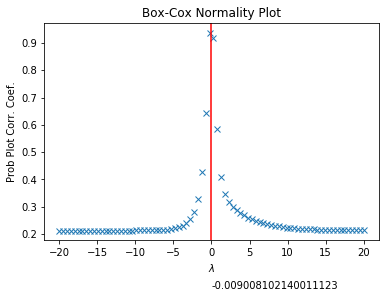

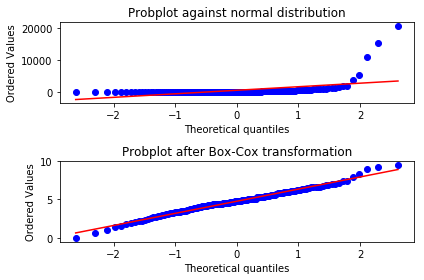

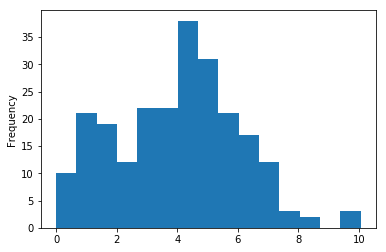

NormaltestResult(statistic=0.8447292274603947, pvalue=0.6554949933417058)
count    233.000000
mean       3.980453
std        2.080528
min        0.000000
25%        2.404845
50%        4.255807
75%        5.269660
max       10.054964
Name: yt, dtype: float64
transformation result for iphone


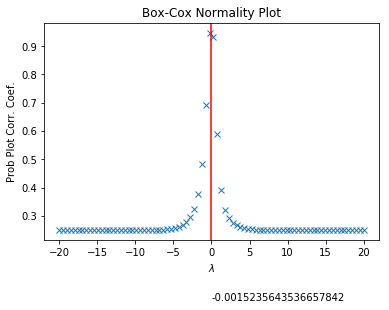

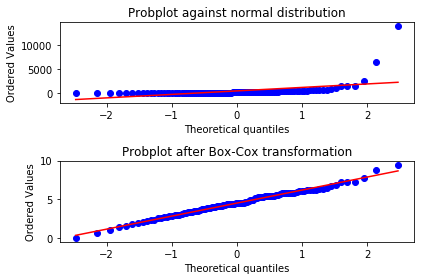

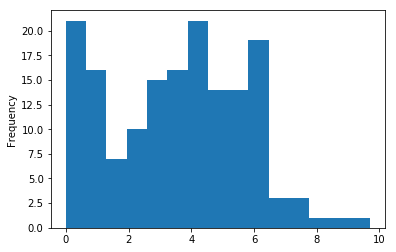

NormaltestResult(statistic=6.91003661811844, pvalue=0.031586726027559076)
count    162.000000
mean       3.485761
std        2.223822
min        0.000000
25%        1.659613
50%        3.772461
75%        5.211034
max        9.703587
Name: yt, dtype: float64
t-test result


Ttest_indResult(statistic=2.259327006238062, pvalue=0.02441017672678766)

In [13]:
analysis(sql1)

# 使用强度-platform

transformation result for android


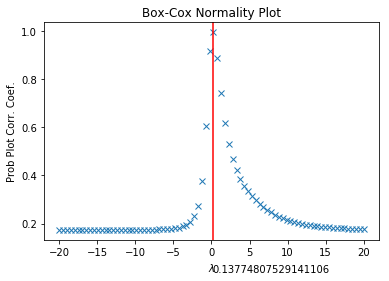

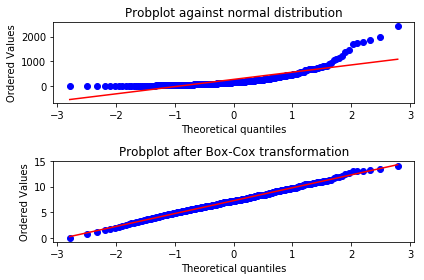

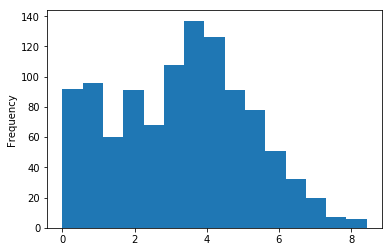

NormaltestResult(statistic=43.263890756970895, pvalue=4.030560916282555e-10)
count    1063.000000
mean        3.288030
std         1.900510
min         0.000000
25%         1.824264
50%         3.483321
75%         4.633155
max         8.436505
Name: yt, dtype: float64
transformation result for iphone


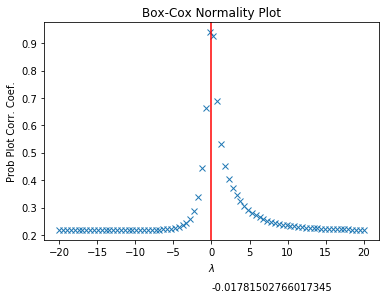

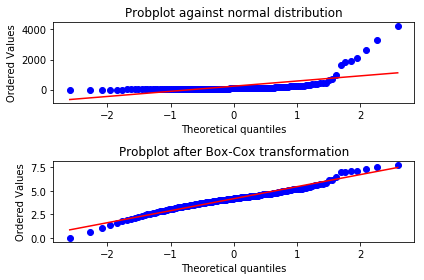

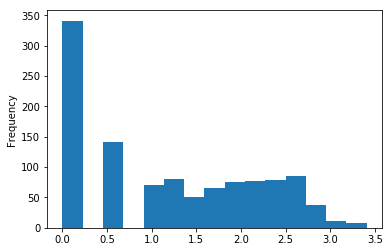

NormaltestResult(statistic=5917.832634418917, pvalue=0.0)
count    1123.000000
mean        1.184364
std         1.003519
min         0.000000
25%         0.000000
50%         1.164044
75%         2.103675
max         3.408480
Name: yt, dtype: float64
t-test result


Ttest_indResult(statistic=32.10069096441827, pvalue=9.285407184751078e-175)

In [14]:
analysis(sql5)

# 访问量-channel

transformation result for app


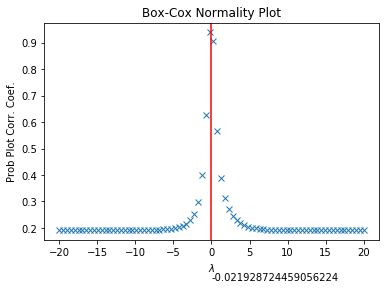

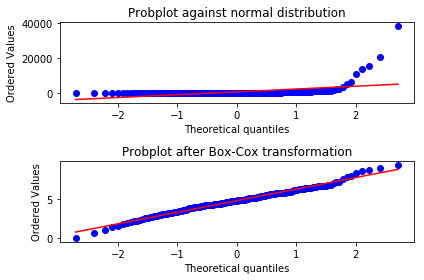

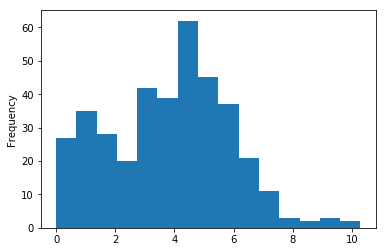

NormaltestResult(statistic=3.595441233167447, pvalue=0.1656760975051018)
count    377.000000
mean       3.778727
std        2.132969
min        0.000000
25%        2.069272
50%        4.087202
75%        5.217885
max       10.290440
Name: yt, dtype: float64
transformation result for browser


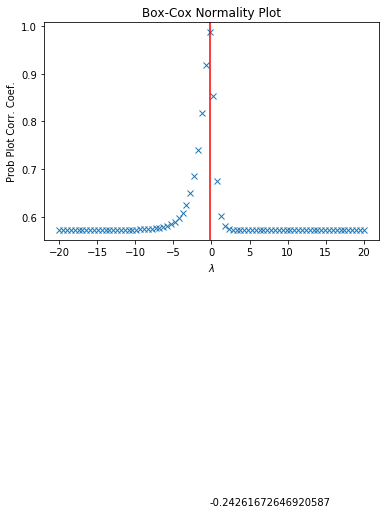

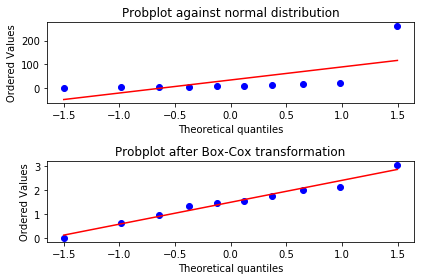

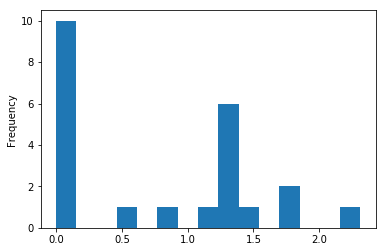

NormaltestResult(statistic=6.114855498157959, pvalue=0.04700845738591393)
count    23.000000
mean      0.779574
std       0.763171
min       0.000000
25%       0.000000
50%       0.897995
75%       1.299224
max       2.312675
Name: yt, dtype: float64
t-test result


Ttest_indResult(statistic=15.510155259256262, pvalue=3.487244197260993e-20)

In [15]:
analysis(sql2)

# 使用强度-channel

transformation result for app


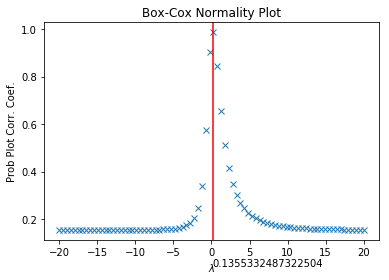

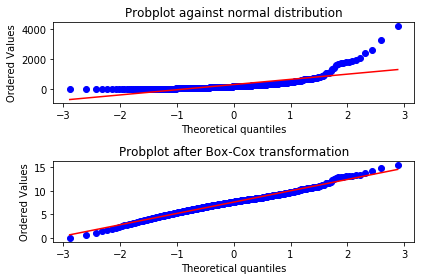

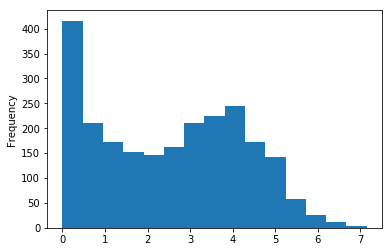

NormaltestResult(statistic=1380.719870131923, pvalue=1.5152687746744258e-300)
count    2355.000000
mean        2.494317
std         1.760221
min         0.000000
25%         0.684051
50%         2.630810
75%         3.921660
max         7.148727
Name: yt, dtype: float64
transformation result for browser


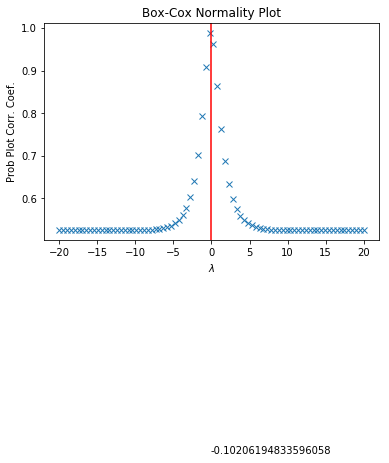

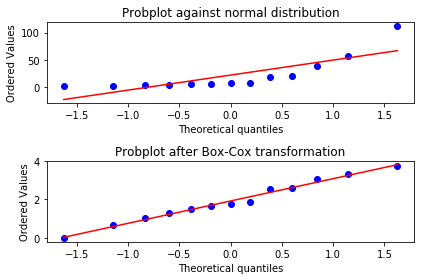

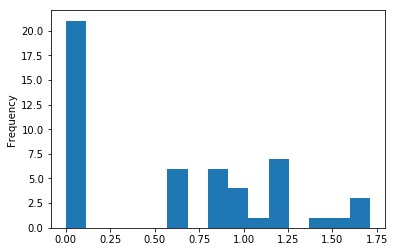

NormaltestResult(statistic=17.39835760621521, pvalue=0.00016672266692307713)
count    50.000000
mean      0.592389
std       0.570145
min       0.000000
25%       0.000000
50%       0.578578
75%       1.051865
max       1.711937
Name: yt, dtype: float64
t-test result


Ttest_indResult(statistic=21.511704656270076, pvalue=9.118615047171548e-33)

In [16]:
analysis(sql6)

# 访问量-gender

transformation result for 女


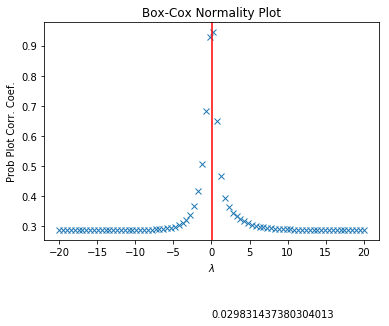

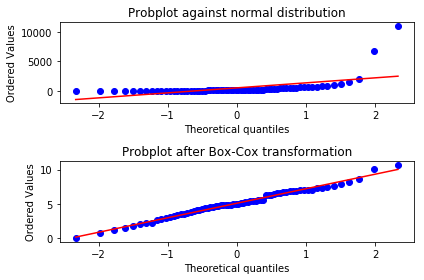

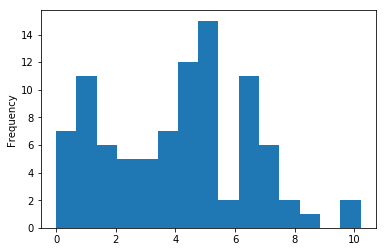

NormaltestResult(statistic=3.742671888842692, pvalue=0.1539178986436156)
count    92.000000
mean      4.055684
std       2.456662
min       0.000000
25%       1.943671
50%       4.476415
75%       6.060201
max      10.208143
Name: yt, dtype: float64
transformation result for 男


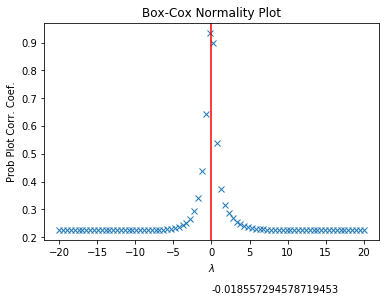

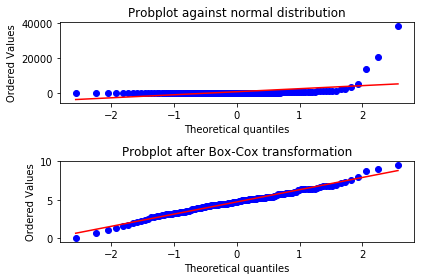

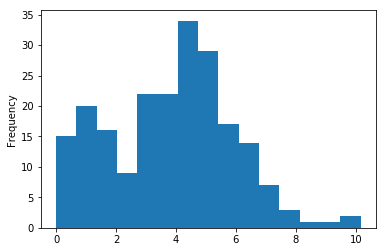

NormaltestResult(statistic=1.637775628205288, pvalue=0.44092176887951606)
count    212.000000
mean       3.825092
std        2.152045
min        0.000000
25%        2.064039
50%        4.089691
75%        5.322006
max       10.160209
Name: yt, dtype: float64
t-test result


Ttest_indResult(statistic=0.8215594434705473, pvalue=0.4119757783678526)

In [17]:
analysis(sql3)

# 使用强度-gender

transformation result for 女


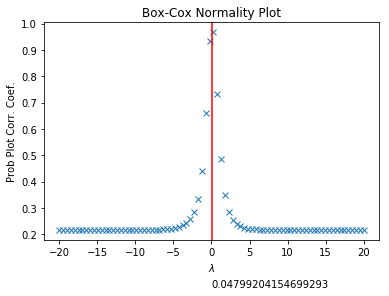

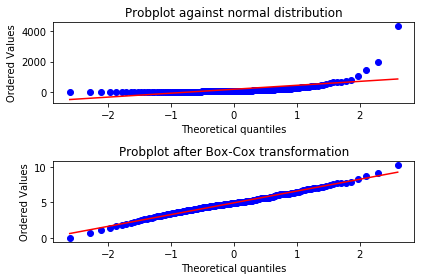

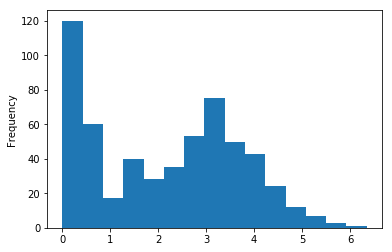

NormaltestResult(statistic=276.8975411811581, pvalue=7.455261927386272e-61)
count    568.000000
mean       2.138704
std        1.581156
min        0.000000
25%        0.676770
50%        2.411884
75%        3.362993
max        6.350829
Name: yt, dtype: float64
transformation result for 男


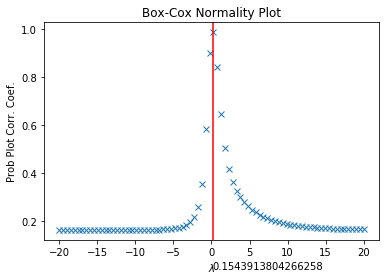

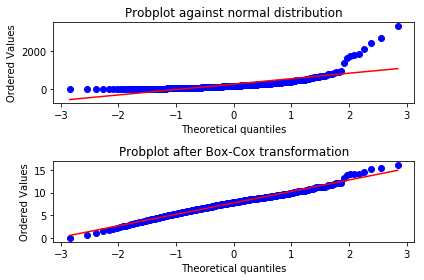

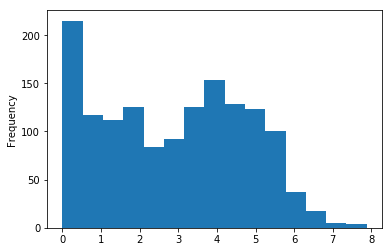

NormaltestResult(statistic=730.4038676060057, pvalue=2.482077678552657e-159)
count    1438.000000
mean        2.837805
std         1.929061
min         0.000000
25%         1.094558
50%         3.059089
75%         4.410503
max         7.880294
Name: yt, dtype: float64
t-test result


Ttest_indResult(statistic=-8.362246607479698, pvalue=1.613470631879505e-16)

In [18]:
analysis(sql7)

# 访问量-income

transformation result for low


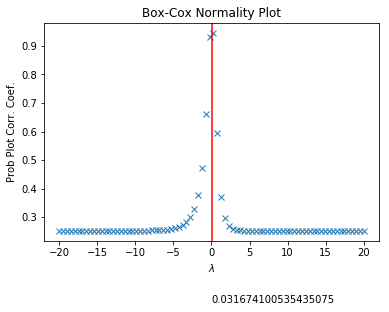

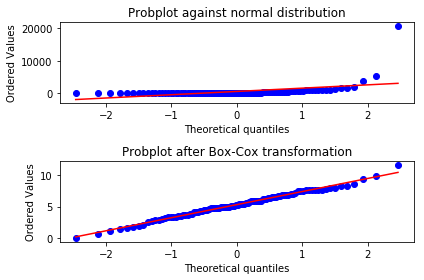

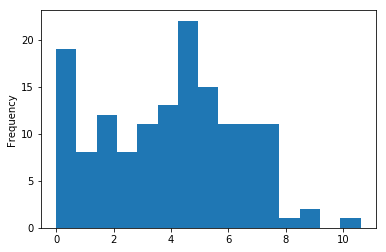

NormaltestResult(statistic=5.331278259000516, pvalue=0.06955488474539784)
count    145.000000
mean       4.029442
std        2.340217
min        0.000000
25%        2.107570
50%        4.351821
75%        5.656345
max       10.599353
Name: yt, dtype: float64
transformation result for high


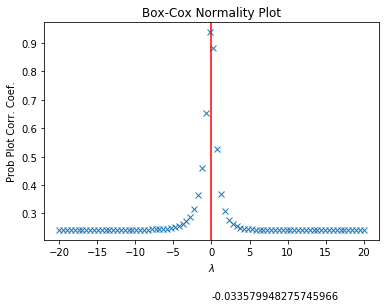

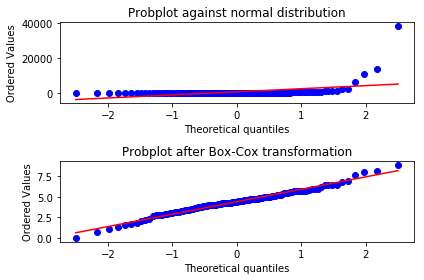

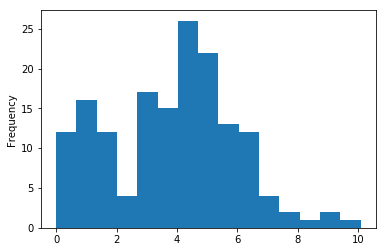

NormaltestResult(statistic=0.7220337238171064, pvalue=0.6969672461698203)
count    159.000000
mean       3.785819
std        2.166653
min        0.000000
25%        2.053299
50%        4.115645
75%        5.194545
max       10.087857
Name: yt, dtype: float64
t-test result


Ttest_indResult(statistic=0.9424802997853992, pvalue=0.3467001117777945)

In [19]:
analysis(sql4)

# 使用强度-income

transformation result for low


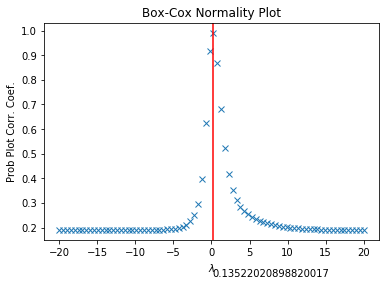

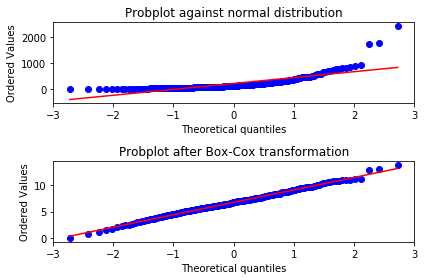

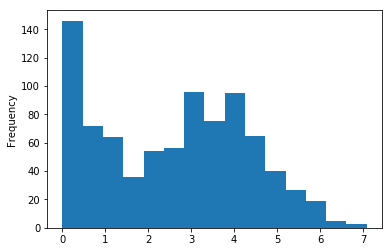

NormaltestResult(statistic=303.0587906863491, pvalue=1.5546039123400482e-66)
count    853.000000
mean       2.565812
std        1.782235
min        0.000000
25%        0.687226
50%        2.789254
75%        3.951684
max        7.088666
Name: yt, dtype: float64
transformation result for high


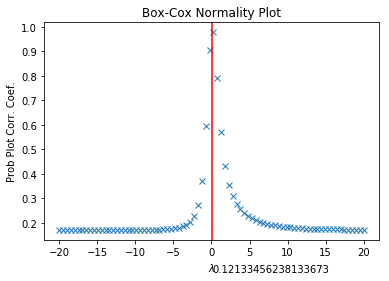

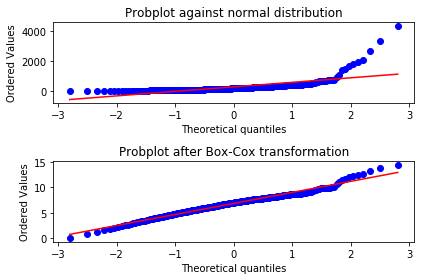

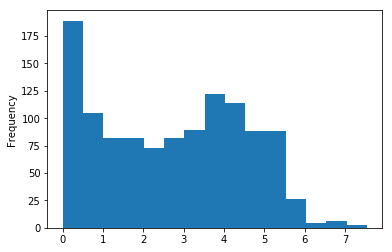

NormaltestResult(statistic=726.6823514816109, pvalue=1.5956304941295315e-158)
count    1153.000000
mean        2.653038
std         1.850756
min         0.000000
25%         0.687134
50%         2.787707
75%         4.203194
max         7.545639
Name: yt, dtype: float64
t-test result


Ttest_indResult(statistic=-1.0660649302062049, pvalue=0.2865317373115386)

In [20]:
analysis(sql8)